# 학습 목표
1. 다중 ADMET 특성을 동시에 예측하는 멀티태스크 모델 구현하기
2. ChemBERTa 사전학습 모델을 활용한 전이학습 적용하기
3. 통합 ADMET 예측 시스템 개발 및 평가하기

# 1. ADMET 예측
- ADMET(Absorption, Distribution, Metabolism, Excretion, Toxicity)는 약물 후보 물질의 생체 내 거동과 안전성을 예측하는 중요한 지표임.
- 신약 개발 과정에서 ADMET 특성이 좋지 않아 실패하는 경우가 많기 때문에, 초기 단계에서 이러한 특성을 정확히 예측하는 것이 매우 중요함.
- 흡수(Absorption): 약물이 체내로 얼마나 잘 흡수되는지 (예: 장 투과성, 생체이용률)
- 분포(Distribution): 약물이 체내 조직과 기관에 어떻게 분포하는지 (예: 혈액-뇌 장벽 투과성, 혈장 단백질 결합률)
- 대사(Metabolism): 약물이 체내에서 어떻게 변환되는지 (예: CYP450 효소에 의한 대사)
- 배설(Excretion): 약물이 체내에서 어떻게 제거되는지 (예: 반감기, 청소율)
- 독성(Toxicity): 약물이 인체에 해로운 영향을 미치는지 (예: 간독성, 심장독성)

# 2. ADMET 예측 실습

https://tdcommons.ai/

## 2.1. 환경 설정 및 데이터 준비

In [ ]:
!pip install PyTDC transformers rdkit

In [ ]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski, MolSurf
from tdc.single_pred import ADME
import warnings
warnings.filterwarnings('ignore')

# 랜덤 시드 설정
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치: {device}")

사용 장치: cuda


In [ ]:
# 선택된 ADMET 데이터셋 리스트
selected_datasets = {
    "absorption": ["Caco2_Wang", "HIA_Hou", "Pgp_Broccatelli"],
    "distribution": ["BBB_Martins", "PPBR_AZ"],
    "metabolism": ["CYP2C19_Veith", "CYP2D6_Veith", "CYP3A4_Veith"],
    "excretion": ["Half_Life_Obach"]
}

# 데이터셋 로드 및 병합 함수
def load_admet_datasets(selected_datasets):
    """TDC에서 ADMET 데이터셋을 로드하고 병합"""
    datasets = {}

    # 각 ADMET 범주와 데이터셋 로드
    for category, dataset_names in selected_datasets.items():
        print(f"\n{category.upper()} 데이터셋 로드 중...")
        for name in dataset_names:
            try:
                data = ADME(name=name)
                split = data.get_split()

                # 학습, 검증, 테스트 세트 가져오기
                train_data = split['train']
                valid_data = split['valid']
                test_data = split['test']

                # 회귀 또는 분류 작업 확인
                unique_values = train_data['Y'].nunique()
                if unique_values <= 2:
                    task_type = 'classification'
                else:
                    task_type = 'regression'

                # 데이터셋 정보 저장
                datasets[name] = {
                    'train': train_data,
                    'valid': valid_data,
                    'test': test_data,
                    'task_type': task_type,
                    'category': category
                }

                print(f"  - {name}: 학습={len(train_data)}, 검증={len(valid_data)}, 테스트={len(test_data)} (작업 유형: {task_type})")
            except Exception as e:
                print(f"  - {name} 로드 중 오류 발생: {e}")

    return datasets

# ADMET 데이터셋 로드
admet_datasets = load_admet_datasets(selected_datasets)

# 데이터셋 정보 출력
print("\n로드된 데이터셋 정보:")
for name, data in admet_datasets.items():
    print(f"{name} ({data['category']}, {data['task_type']}): 학습={len(data['train'])}, 검증={len(data['valid'])}, 테스트={len(data['test'])}")

Downloading...



ABSORPTION 데이터셋 로드 중...


100%|██████████| 82.5k/82.5k [00:00<00:00, 380kiB/s]
Loading...
Done!
Downloading...


  - Caco2_Wang: 학습=637, 검증=91, 테스트=182 (작업 유형: regression)


100%|██████████| 40.1k/40.1k [00:00<00:00, 30.8MiB/s]
Loading...
Done!
Downloading...


  - HIA_Hou: 학습=404, 검증=58, 테스트=116 (작업 유형: classification)


100%|██████████| 126k/126k [00:00<00:00, 193kiB/s] 
Loading...
Done!
Downloading...


  - Pgp_Broccatelli: 학습=852, 검증=122, 테스트=244 (작업 유형: classification)

DISTRIBUTION 데이터셋 로드 중...


100%|██████████| 138k/138k [00:00<00:00, 320kiB/s] 
Loading...
Done!
Downloading...


  - BBB_Martins: 학습=1421, 검증=203, 테스트=406 (작업 유형: classification)


100%|██████████| 265k/265k [00:00<00:00, 406kiB/s]
Loading...
Done!
Downloading...


  - PPBR_AZ: 학습=1130, 검증=161, 테스트=323 (작업 유형: regression)

METABOLISM 데이터셋 로드 중...


100%|██████████| 771k/771k [00:01<00:00, 711kiB/s]
Loading...
Done!
Downloading...


  - CYP2C19_Veith: 학습=8866, 검증=1266, 테스트=2533 (작업 유형: classification)


100%|██████████| 800k/800k [00:00<00:00, 923kiB/s]
Loading...
Done!
Downloading...


  - CYP2D6_Veith: 학습=9191, 검증=1313, 테스트=2626 (작업 유형: classification)


100%|██████████| 746k/746k [00:00<00:00, 860kiB/s]
Loading...
Done!
Downloading...


  - CYP3A4_Veith: 학습=8629, 검증=1233, 테스트=2466 (작업 유형: classification)

EXCRETION 데이터셋 로드 중...


100%|██████████| 53.6k/53.6k [00:00<00:00, 249kiB/s]
Loading...
Done!


  - Half_Life_Obach: 학습=467, 검증=67, 테스트=133 (작업 유형: regression)

로드된 데이터셋 정보:
Caco2_Wang (absorption, regression): 학습=637, 검증=91, 테스트=182
HIA_Hou (absorption, classification): 학습=404, 검증=58, 테스트=116
Pgp_Broccatelli (absorption, classification): 학습=852, 검증=122, 테스트=244
BBB_Martins (distribution, classification): 학습=1421, 검증=203, 테스트=406
PPBR_AZ (distribution, regression): 학습=1130, 검증=161, 테스트=323
CYP2C19_Veith (metabolism, classification): 학습=8866, 검증=1266, 테스트=2533
CYP2D6_Veith (metabolism, classification): 학습=9191, 검증=1313, 테스트=2626
CYP3A4_Veith (metabolism, classification): 학습=8629, 검증=1233, 테스트=2466
Half_Life_Obach (excretion, regression): 학습=467, 검증=67, 테스트=133


## 2.2. 데이터 전처리

In [ ]:
# 선택된 ADMET 데이터셋 리스트
selected_datasets = {
    "absorption": ["Caco2_Wang", "HIA_Hou", "Pgp_Broccatelli"],
    "distribution": ["BBB_Martins", "PPBR_AZ"],
    "metabolism": ["CYP2C19_Veith", "CYP2D6_Veith", "CYP3A4_Veith"],
    "excretion": ["Half_Life_Obach"]
}

# 데이터셋 로드 및 병합 함수
def load_admet_datasets(selected_datasets):
    """TDC에서 ADMET 데이터셋을 로드하고 병합"""
    datasets = {}

    # 각 ADMET 범주와 데이터셋 로드
    for category, dataset_names in selected_datasets.items():
        print(f"\n{category.upper()} 데이터셋 로드 중...")
        for name in dataset_names:
            try:
                data = ADME(name=name)
                split = data.get_split()

                # 학습, 검증, 테스트 세트 가져오기
                train_data = split['train']
                valid_data = split['valid']
                test_data = split['test']

                # 회귀 또는 분류 작업 확인
                unique_values = train_data['Y'].nunique()
                if unique_values <= 2:
                    task_type = 'classification'
                else:
                    task_type = 'regression'

                # 데이터셋 정보 저장
                datasets[name] = {
                    'train': train_data,
                    'valid': valid_data,
                    'test': test_data,
                    'task_type': task_type,
                    'category': category
                }

                print(f"  - {name}: 학습={len(train_data)}, 검증={len(valid_data)}, 테스트={len(test_data)} (작업 유형: {task_type})")
            except Exception as e:
                print(f"  - {name} 로드 중 오류 발생: {e}")

    return datasets

# ADMET 데이터셋 로드
admet_datasets = load_admet_datasets(selected_datasets)

# 데이터셋 정보 출력
print("\n로드된 데이터셋 정보:")
for name, data in admet_datasets.items():
    print(f"{name} ({data['category']}, {data['task_type']}): 학습={len(data['train'])}, 검증={len(data['valid'])}, 테스트={len(data['test'])}")


Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!



ABSORPTION 데이터셋 로드 중...
  - Caco2_Wang: 학습=637, 검증=91, 테스트=182 (작업 유형: regression)
  - HIA_Hou: 학습=404, 검증=58, 테스트=116 (작업 유형: classification)
  - Pgp_Broccatelli: 학습=852, 검증=122, 테스트=244 (작업 유형: classification)

DISTRIBUTION 데이터셋 로드 중...
  - BBB_Martins: 학습=1421, 검증=203, 테스트=406 (작업 유형: classification)
  - PPBR_AZ: 학습=1130, 검증=161, 테스트=323 (작업 유형: regression)

METABOLISM 데이터셋 로드 중...
  - CYP2C19_Veith: 학습=8866, 검증=1266, 테스트=2533 (작업 유형: classification)
  - CYP2D6_Veith: 학습=9191, 검증=1313, 테스트=2626 (작업 유형: classification)
  - CYP3A4_Veith: 학습=8629, 검증=1233, 테스트=2466 (작업 유형: classification)

EXCRETION 데이터셋 로드 중...
  - Half_Life_Obach: 학습=467, 검증=67, 테스트=133 (작업 유형: regression)

로드된 데이터셋 정보:
Caco2_Wang (absorption, regression): 학습=637, 검증=91, 테스트=182
HIA_Hou (absorption, classification): 학습=404, 검증=58, 테스트=116
Pgp_Broccatelli (absorption, classification): 학습=852, 검증=122, 테스트=244
BBB_Martins (distribution, classification): 학습=1421, 검증=203, 테스트=406
PPBR_AZ (distribution, regression): 학습=11

In [ ]:
# 분자 특성 추출 함수
def extract_molecular_features(smiles):
    """SMILES 문자열에서 분자 특성 추출"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        features = {}

        # 기본 물리화학적 특성
        features['MW'] = Descriptors.MolWt(mol)
        features['LogP'] = Descriptors.MolLogP(mol)
        features['HBD'] = Descriptors.NumHDonors(mol)
        features['HBA'] = Descriptors.NumHAcceptors(mol)
        features['RotBonds'] = Descriptors.NumRotatableBonds(mol)
        features['TPSA'] = Descriptors.TPSA(mol)
        features['QED'] = Descriptors.qed(mol)

        # 추가 특성
        features['AromaticRings'] = Lipinski.NumAromaticRings(mol)
        features['HeavyAtoms'] = mol.GetNumHeavyAtoms()
        features['Rings'] = Descriptors.RingCount(mol)
        features['MolMR'] = Descriptors.MolMR(mol)
        features['FractionCSP3'] = Descriptors.FractionCSP3(mol)
        features['NumHeteroatoms'] = Lipinski.NumHeteroatoms(mol)
        features['LabuteASA'] = Descriptors.LabuteASA(mol)

        # 원자 개수
        features['NumC'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)
        features['NumN'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 7)
        features['NumO'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8)
        features['NumS'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 16)
        features['NumF'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 9)
        features['NumCl'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 17)
        features['NumBr'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 35)
        features['NumI'] = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 53)

        # MACCS 지문 (166비트)
        maccs = list(AllChem.GetMACCSKeysFingerprint(mol))
        for i, bit in enumerate(maccs):
            features[f'MACCS_{i}'] = int(bit)

        return features
    except:
        return None

# 데이터셋 특성 추출
def prepare_dataset_features(dataset):
    """데이터셋의 모든 분자에 대한 특성 추출"""
    smiles_list = dataset['Drug'].tolist()
    features_list = []
    valid_indices = []

    for i, smiles in enumerate(tqdm(smiles_list, desc="특성 추출 중")):
        features = extract_molecular_features(smiles)
        if features is not None:
            features_list.append(features)
            valid_indices.append(i)

    # 유효한 분자만 선택
    valid_df = dataset.iloc[valid_indices].reset_index(drop=True)

    # 특성 데이터프레임 생성
    features_df = pd.DataFrame(features_list)

    return valid_df, features_df

In [ ]:
# 각 데이터셋에 대한 특성 추출 및 준비
def prepare_all_datasets(admet_datasets):
    """모든 ADMET 데이터셋에 대한 특성 추출 및 준비"""
    prepared_datasets = {}

    for name, data in admet_datasets.items():
        print(f"\n{name} 데이터셋 준비 중...")

        # 학습, 검증, 테스트 세트에 대한 특성 추출
        train_df, train_features = prepare_dataset_features(data['train'])
        valid_df, valid_features = prepare_dataset_features(data['valid'])
        test_df, test_features = prepare_dataset_features(data['test'])

        # 특성 스케일링을 위한 스케일러 학습
        scaler = StandardScaler()
        scaler.fit(train_features)

        # 특성 스케일링 적용
        train_features_scaled = scaler.transform(train_features)
        valid_features_scaled = scaler.transform(valid_features)
        test_features_scaled = scaler.transform(test_features)

        # 데이터셋 정보 저장
        prepared_datasets[name] = {
            'train': (train_df, train_features_scaled),
            'valid': (valid_df, valid_features_scaled),
            'test': (test_df, test_features_scaled),
            'task_type': data['task_type'],
            'category': data['category'],
            'feature_names': train_features.columns.tolist(),
            'scaler': scaler,
            'n_features': train_features.shape[1]
        }

        print(f"  - 학습: {len(train_df)}개 샘플, 검증: {len(valid_df)}개 샘플, 테스트: {len(test_df)}개 샘플")
        print(f"  - 추출된 특성 수: {train_features.shape[1]}")

    return prepared_datasets

# 모든 데이터셋 준비
prepared_datasets = prepare_all_datasets(admet_datasets)


Caco2_Wang 데이터셋 준비 중...


특성 추출 중: 100%|██████████| 182/182 [00:00<00:00, 258.55it/s]


  - 학습: 637개 샘플, 검증: 91개 샘플, 테스트: 182개 샘플
  - 추출된 특성 수: 189

HIA_Hou 데이터셋 준비 중...


특성 추출 중: 100%|██████████| 116/116 [00:00<00:00, 300.72it/s]


  - 학습: 404개 샘플, 검증: 58개 샘플, 테스트: 116개 샘플
  - 추출된 특성 수: 189

Pgp_Broccatelli 데이터셋 준비 중...


특성 추출 중: 100%|██████████| 244/244 [00:01<00:00, 169.38it/s]


  - 학습: 852개 샘플, 검증: 122개 샘플, 테스트: 244개 샘플
  - 추출된 특성 수: 189

BBB_Martins 데이터셋 준비 중...


특성 추출 중:   4%|▍         | 60/1421 [00:00<00:04, 278.90it/s][11:45:07] WARNING: not removing hydrogen atom without neighbors
[11:45:07] WARNING: not removing hydrogen atom without neighbors
특성 추출 중:  10%|█         | 147/1421 [00:00<00:04, 259.78it/s][11:45:07] WARNING: not removing hydrogen atom without neighbors
[11:45:07] WARNING: not removing hydrogen atom without neighbors
특성 추출 중:  28%|██▊       | 401/1421 [00:01<00:03, 290.09it/s][11:45:08] WARNING: not removing hydrogen atom without neighbors
[11:45:08] WARNING: not removing hydrogen atom without neighbors
특성 추출 중:  30%|███       | 431/1421 [00:01<00:03, 290.43it/s][11:45:08] WARNING: not removing hydrogen atom without neighbors
[11:45:08] WARNING: not removing hydrogen atom without neighbors
[11:45:08] WARNING: not removing hydrogen atom without neighbors
[11:45:08] WARNING: not removing hydrogen atom without neighbors
특성 추출 중:  35%|███▍      | 491/1421 [00:01<00:03, 288.61it/s][11:45:09] WARNING: not removing hydrogen atom with

  - 학습: 1421개 샘플, 검증: 203개 샘플, 테스트: 406개 샘플
  - 추출된 특성 수: 189

PPBR_AZ 데이터셋 준비 중...


특성 추출 중: 100%|██████████| 323/323 [00:01<00:00, 253.79it/s]


  - 학습: 1130개 샘플, 검증: 161개 샘플, 테스트: 323개 샘플
  - 추출된 특성 수: 189

CYP2C19_Veith 데이터셋 준비 중...


특성 추출 중: 100%|██████████| 2533/2533 [00:09<00:00, 255.99it/s]


  - 학습: 8866개 샘플, 검증: 1266개 샘플, 테스트: 2533개 샘플
  - 추출된 특성 수: 189

CYP2D6_Veith 데이터셋 준비 중...


특성 추출 중: 100%|██████████| 2626/2626 [00:10<00:00, 257.72it/s]


  - 학습: 9191개 샘플, 검증: 1313개 샘플, 테스트: 2626개 샘플
  - 추출된 특성 수: 189

CYP3A4_Veith 데이터셋 준비 중...


특성 추출 중: 100%|██████████| 2466/2466 [00:09<00:00, 258.57it/s]


  - 학습: 8629개 샘플, 검증: 1233개 샘플, 테스트: 2466개 샘플
  - 추출된 특성 수: 189

Half_Life_Obach 데이터셋 준비 중...


특성 추출 중: 100%|██████████| 133/133 [00:00<00:00, 222.42it/s]

  - 학습: 467개 샘플, 검증: 67개 샘플, 테스트: 133개 샘플
  - 추출된 특성 수: 189


In [ ]:
# ADMET 멀티태스크 데이터셋 클래스
class ADMETMultitaskDataset(Dataset):
    def __init__(self, datasets, dataset_names, split='train'):
        """
        datasets: 준비된 데이터셋 사전
        dataset_names: 사용할 데이터셋 이름 목록
        split: 데이터 분할 ('train', 'valid', 'test')
        """
        self.datasets = datasets
        self.dataset_names = dataset_names
        self.split = split

        # 각 데이터셋의 샘플 수 계산
        self.dataset_sizes = {}
        self.total_size = 0

        for name in dataset_names:
            df, _ = datasets[name][split]
            size = len(df)
            self.dataset_sizes[name] = size
            self.total_size += size

        # 데이터셋 인덱스 매핑 생성
        self.dataset_indices = []
        self.global_to_local = []

        idx = 0
        for name in dataset_names:
            size = self.dataset_sizes[name]
            for i in range(size):
                self.dataset_indices.append(name)
                self.global_to_local.append(i)
                idx += 1

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        # 해당 인덱스의 데이터셋 및 로컬 인덱스 찾기
        dataset_name = self.dataset_indices[idx]
        local_idx = self.global_to_local[idx]

        # 데이터셋에서 샘플 가져오기
        df, features = self.datasets[dataset_name][self.split]

        # 특성 및 레이블 추출
        x = features[local_idx]
        y = df['Y'].iloc[local_idx]

        # 작업 유형 확인 (분류 또는 회귀)
        task_type = 1 if self.datasets[dataset_name]['task_type'] == 'classification' else 0

        # 데이터셋 인덱스 (이름 -> 숫자 매핑)
        dataset_idx = self.dataset_names.index(dataset_name)

        return {
            'features': torch.tensor(x, dtype=torch.float32),
            'label': torch.tensor(y, dtype=torch.float32),
            'dataset_idx': dataset_idx,
            'task_type': task_type
        }

# 데이터로더 생성 함수
def create_dataloaders(prepared_datasets, dataset_names, batch_size=32):
    """데이터로더 생성"""
    # 데이터셋 생성
    train_dataset = ADMETMultitaskDataset(prepared_datasets, dataset_names, 'train')
    valid_dataset = ADMETMultitaskDataset(prepared_datasets, dataset_names, 'valid')
    test_dataset = ADMETMultitaskDataset(prepared_datasets, dataset_names, 'test')

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, valid_loader, test_loader

# 사용할 데이터셋 이름 목록
dataset_names = list(prepared_datasets.keys())

# 데이터로더 생성
batch_size = 64
train_loader, valid_loader, test_loader = create_dataloaders(
    prepared_datasets, dataset_names, batch_size)

print(f"데이터셋 이름: {dataset_names}")
print(f"총 작업 수: {len(dataset_names)}")

데이터셋 이름: ['Caco2_Wang', 'HIA_Hou', 'Pgp_Broccatelli', 'BBB_Martins', 'PPBR_AZ', 'CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith', 'Half_Life_Obach']
총 작업 수: 9


## 2.3. 모델 정의

In [ ]:
# 멀티태스크 ADMET 예측 모델
class MultitaskADMETPredictor(nn.Module):
    def __init__(self, input_dim, num_tasks, hidden_dims=[512, 256, 128], dropout_rate=0.2):
        super(MultitaskADMETPredictor, self).__init__()

        # 공유 레이어
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.Dropout(dropout_rate)
        )

        # 작업별 헤드
        self.task_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dims[1], hidden_dims[2]),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dims[2], 1)
            ) for _ in range(num_tasks)
        ])

        # 시그모이드 활성화 함수 (분류 작업용)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dataset_idx=None, task_types=None):
        # 공유 레이어 통과
        shared_features = self.shared_layers(x)

        # 단일 작업 예측 모드
        if dataset_idx is not None:
            # 특정 작업에 대한 예측
            task_preds = self.task_heads[dataset_idx](shared_features)

            # 분류 작업인 경우 시그모이드 적용
            if task_types is not None and task_types == 1:
                task_preds = self.sigmoid(task_preds)

            return task_preds

        # 배치 내 다중 작업 예측 모드
        else:
            # 모든 작업에 대한 예측
            all_preds = []
            for i, head in enumerate(self.task_heads):
                preds = head(shared_features)
                all_preds.append(preds)

            return all_preds

# 모델 초기화
input_dim = next(iter(prepared_datasets.values()))['n_features']
num_tasks = len(dataset_names)
model = MultitaskADMETPredictor(input_dim, num_tasks).to(device)
print(f"모델이 {num_tasks}개 작업을 위해 초기화되었습니다.")
print(f"입력 차원: {input_dim}")

모델이 9개 작업을 위해 초기화되었습니다.
입력 차원: 189


In [ ]:
# 작업별 손실 함수
def get_task_loss(predictions, labels, task_type):
    """작업 유형에 따른 손실 함수"""
    if task_type == 1:  # 분류 작업
        # 레이블 범위를 [0, 1]로 확인하고 조정
        labels = torch.clamp(labels, 0, 1)
        return nn.BCEWithLogitsLoss()(predictions, labels.view(-1, 1))
    else:  # 회귀 작업
        return nn.MSELoss()(predictions, labels.view(-1, 1))

# 평가 지표 계산 함수
def compute_metrics(predictions, labels, task_types, dataset_indices, dataset_names):
    """작업별 평가 지표 계산"""
    metrics = {}

    # 각 데이터셋별로 지표 계산
    for i, dataset in enumerate(dataset_names):
        # 해당 데이터셋의 샘플 선택
        mask = [idx == i for idx in dataset_indices]
        if not any(mask):
            continue

        ds_preds = [p for p, m in zip(predictions, mask) if m]
        ds_labels = [l for l, m in zip(labels, mask) if m]
        ds_task_type = [t for t, m in zip(task_types, mask) if m][0]  # 첫 번째 값으로 작업 유형 결정

        # 분류 작업
        if ds_task_type == 1:
            try:
                # 이진 분류를 위한 임계값 적용
                ds_preds_binary = [1 if p >= 0.5 else 0 for p in ds_preds]
                accuracy = accuracy_score(ds_labels, ds_preds_binary)

                # 레이블 확인 및 조정
                unique_labels = np.unique(ds_labels)
                if len(unique_labels) > 1:  # 두 클래스 이상 존재
                    auroc = roc_auc_score(ds_labels, ds_preds)
                else:  # 단일 클래스만 존재
                    auroc = 0.5  # 기본값

                metrics[dataset] = {
                    'Accuracy': accuracy,
                    'AUROC': auroc
                }
            except Exception as e:
                print(f"경고: {dataset} 지표 계산 중 오류 - {e}")
                metrics[dataset] = {
                    'Accuracy': float('nan'),
                    'AUROC': float('nan')
                }
        # 회귀 작업
        else:
            try:
                rmse = np.sqrt(mean_squared_error(ds_labels, ds_preds))
                r2 = r2_score(ds_labels, ds_preds)
                metrics[dataset] = {
                    'RMSE': rmse,
                    'R2': r2
                }
            except Exception as e:
                print(f"경고: {dataset} 지표 계산 중 오류 - {e}")
                metrics[dataset] = {
                    'RMSE': float('nan'),
                    'R2': float('nan')
                }

    return metrics


## 2.4. 모델 학습

In [ ]:
# 모델 학습 함수
def train_model(model, train_loader, val_loader, optimizer, dataset_names, num_epochs=10):
    """모델 학습 및 검증"""
    best_val_loss = float('inf')
    best_model_state = None
    training_history = {
        'train_loss': [],
        'val_loss': [],
        'val_metrics': []
    }

    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        total_loss = 0

        # 진행 상황 표시
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            # 배치 데이터를 장치로 이동
            features = batch['features'].to(device)
            dataset_indices = batch['dataset_idx'].tolist()
            labels = batch['label'].to(device)
            task_types = batch['task_type'].tolist()

            # 최적화 함수 초기화
            optimizer.zero_grad()

            # 모든 작업에 대한 예측
            all_task_preds = model(features)

            # 손실 계산
            loss = 0
            batch_size = features.size(0)

            for i in range(batch_size):
                task_idx = dataset_indices[i]
                task_pred = all_task_preds[task_idx][i]
                task_label = labels[i]
                task_type = task_types[i]

                # 작업별 손실 계산
                task_loss = get_task_loss(task_pred.unsqueeze(0), task_label.unsqueeze(0), task_type)
                loss += task_loss

            # 평균 손실
            loss /= batch_size

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        # 에폭 평균 손실
        avg_train_loss = total_loss / len(train_loader)
        training_history['train_loss'].append(avg_train_loss)

        # 검증
        val_loss, val_metrics = evaluate_model(model, val_loader, dataset_names)
        training_history['val_loss'].append(val_loss)
        training_history['val_metrics'].append(val_metrics)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # 최적 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"Best model saved with val_loss: {val_loss:.4f}")

        # 작업별 성능 출력
        print("검증 세트 성능:")
        for dataset, metrics in val_metrics.items():
            metric_str = ", ".join([f"{k}: {v:.4f}" for k, v in metrics.items()])
            print(f"  - {dataset}: {metric_str}")

    # 최적 모델 복원
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, training_history

# 모델 평가 함수
def evaluate_model(model, data_loader, dataset_names):
    """모델 평가"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_task_types = []
    all_dataset_indices = []

    with torch.no_grad():
        for batch in data_loader:
            # 배치 데이터를 장치로 이동
            features = batch['features'].to(device)
            dataset_indices = batch['dataset_idx'].tolist()
            labels = batch['label'].to(device)
            task_types = batch['task_type'].tolist()

            # 모든 작업에 대한 예측
            all_task_preds = model(features)

            # 손실 계산
            loss = 0
            batch_size = features.size(0)
            batch_predictions = []

            for i in range(batch_size):
                task_idx = dataset_indices[i]
                task_pred = all_task_preds[task_idx][i]
                task_label = labels[i]
                task_type = task_types[i]

                # 작업별 손실 계산
                task_loss = get_task_loss(task_pred.unsqueeze(0), task_label.unsqueeze(0), task_type)
                loss += task_loss

                # 예측 저장
                pred_value = task_pred.item()
                if task_type == 1:  # 분류 작업인 경우 시그모이드 적용
                    pred_value = torch.sigmoid(task_pred).item()
                batch_predictions.append(pred_value)

            # 평균 손실
            loss /= batch_size
            total_loss += loss.item()

            # 예측 및 레이블 저장
            all_predictions.extend(batch_predictions)
            all_labels.extend(labels.cpu().numpy())
            all_task_types.extend(task_types)
            all_dataset_indices.extend(dataset_indices)

    # 평균 손실
    avg_loss = total_loss / len(data_loader)

    # 평가 지표 계산
    metrics = compute_metrics(
        all_predictions, all_labels, all_task_types, all_dataset_indices, dataset_names)

    return avg_loss, metrics


In [ ]:
# 학습 파라미터 설정
learning_rate = 0.001
num_epochs = 20
weight_decay = 0.0001

# 최적화 함수
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 모델 학습
print("모델 학습 시작...")
trained_model, history = train_model(
    model, train_loader, valid_loader, optimizer, dataset_names, num_epochs)

# 모델 저장
torch.save(trained_model.state_dict(), 'admet_model.pt')
print("모델이 'admet_model.pt'에 저장되었습니다.")

모델 학습 시작...


Epoch 1/20: 100%|██████████| 494/494 [00:14<00:00, 34.02it/s, loss=27]


Epoch 1/20, Train Loss: 150.9745, Val Loss: 19.8649
Best model saved with val_loss: 19.8649
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.9265, R2: -0.8435
  - HIA_Hou: Accuracy: 0.9138, AUROC: 0.9231
  - Pgp_Broccatelli: Accuracy: 0.6967, AUROC: 0.8133
  - BBB_Martins: Accuracy: 0.8177, AUROC: 0.8207
  - PPBR_AZ: RMSE: 14.8847, R2: -0.1578
  - CYP2C19_Veith: Accuracy: 0.7180, AUROC: 0.7814
  - CYP2D6_Veith: Accuracy: 0.8027, AUROC: 0.7320
  - CYP3A4_Veith: Accuracy: 0.6861, AUROC: 0.7578
  - Half_Life_Obach: RMSE: 25.0076, R2: -0.0913


Epoch 2/20: 100%|██████████| 494/494 [00:13<00:00, 36.50it/s, loss=4.23]


Epoch 2/20, Train Loss: 90.0689, Val Loss: 20.0437
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.9381, R2: -0.8900
  - HIA_Hou: Accuracy: 0.8793, AUROC: 0.9135
  - Pgp_Broccatelli: Accuracy: 0.7623, AUROC: 0.8428
  - BBB_Martins: Accuracy: 0.8374, AUROC: 0.8354
  - PPBR_AZ: RMSE: 15.5797, R2: -0.2684
  - CYP2C19_Veith: Accuracy: 0.7101, AUROC: 0.7868
  - CYP2D6_Veith: Accuracy: 0.8012, AUROC: 0.7189
  - CYP3A4_Veith: Accuracy: 0.7056, AUROC: 0.7809
  - Half_Life_Obach: RMSE: 24.4788, R2: -0.0456


Epoch 3/20: 100%|██████████| 494/494 [00:13<00:00, 36.72it/s, loss=1.61]


Epoch 3/20, Train Loss: 87.2817, Val Loss: 15.4110
Best model saved with val_loss: 15.4110
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.6708, R2: 0.0337
  - HIA_Hou: Accuracy: 0.9310, AUROC: 0.9487
  - Pgp_Broccatelli: Accuracy: 0.8197, AUROC: 0.8555
  - BBB_Martins: Accuracy: 0.8621, AUROC: 0.8620
  - PPBR_AZ: RMSE: 13.4298, R2: 0.0575
  - CYP2C19_Veith: Accuracy: 0.7259, AUROC: 0.8020
  - CYP2D6_Veith: Accuracy: 0.8020, AUROC: 0.7543
  - CYP3A4_Veith: Accuracy: 0.7226, AUROC: 0.7942
  - Half_Life_Obach: RMSE: 21.1835, R2: 0.2170


Epoch 4/20: 100%|██████████| 494/494 [00:13<00:00, 35.89it/s, loss=11.8]


Epoch 4/20, Train Loss: 82.8613, Val Loss: 19.5246
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.9867, R2: -1.0910
  - HIA_Hou: Accuracy: 0.9483, AUROC: 0.8974
  - Pgp_Broccatelli: Accuracy: 0.7705, AUROC: 0.8653
  - BBB_Martins: Accuracy: 0.8768, AUROC: 0.8357
  - PPBR_AZ: RMSE: 15.1582, R2: -0.2007
  - CYP2C19_Veith: Accuracy: 0.7267, AUROC: 0.8090
  - CYP2D6_Veith: Accuracy: 0.8081, AUROC: 0.7593
  - CYP3A4_Veith: Accuracy: 0.6991, AUROC: 0.7740
  - Half_Life_Obach: RMSE: 24.2816, R2: -0.0288


Epoch 5/20: 100%|██████████| 494/494 [00:13<00:00, 36.55it/s, loss=15.5]


Epoch 5/20, Train Loss: 81.3466, Val Loss: 15.3567
Best model saved with val_loss: 15.3567
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.9058, R2: -0.7621
  - HIA_Hou: Accuracy: 0.9310, AUROC: 0.9615
  - Pgp_Broccatelli: Accuracy: 0.7705, AUROC: 0.8785
  - BBB_Martins: Accuracy: 0.8867, AUROC: 0.8692
  - PPBR_AZ: RMSE: 13.9848, R2: -0.0220
  - CYP2C19_Veith: Accuracy: 0.7385, AUROC: 0.8164
  - CYP2D6_Veith: Accuracy: 0.8264, AUROC: 0.7551
  - CYP3A4_Veith: Accuracy: 0.7113, AUROC: 0.7991
  - Half_Life_Obach: RMSE: 20.3017, R2: 0.2808


Epoch 6/20: 100%|██████████| 494/494 [00:13<00:00, 36.47it/s, loss=0.486]


Epoch 6/20, Train Loss: 73.3084, Val Loss: 28.5538
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.9289, R2: -0.8529
  - HIA_Hou: Accuracy: 0.9483, AUROC: 0.9487
  - Pgp_Broccatelli: Accuracy: 0.7787, AUROC: 0.8874
  - BBB_Martins: Accuracy: 0.8867, AUROC: 0.8705
  - PPBR_AZ: RMSE: 13.9876, R2: -0.0224
  - CYP2C19_Veith: Accuracy: 0.7306, AUROC: 0.8121
  - CYP2D6_Veith: Accuracy: 0.8241, AUROC: 0.7471
  - CYP3A4_Veith: Accuracy: 0.7113, AUROC: 0.7924
  - Half_Life_Obach: RMSE: 33.5572, R2: -0.9650


Epoch 7/20: 100%|██████████| 494/494 [00:13<00:00, 36.69it/s, loss=6.69]


Epoch 7/20, Train Loss: 70.7585, Val Loss: 24.6890
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.9700, R2: -1.0207
  - HIA_Hou: Accuracy: 0.9483, AUROC: 0.9263
  - Pgp_Broccatelli: Accuracy: 0.7131, AUROC: 0.8374
  - BBB_Martins: Accuracy: 0.8916, AUROC: 0.8622
  - PPBR_AZ: RMSE: 12.6653, R2: 0.1617
  - CYP2C19_Veith: Accuracy: 0.7220, AUROC: 0.8059
  - CYP2D6_Veith: Accuracy: 0.8309, AUROC: 0.7657
  - CYP3A4_Veith: Accuracy: 0.7299, AUROC: 0.8014
  - Half_Life_Obach: RMSE: 30.6389, R2: -0.6381


Epoch 8/20: 100%|██████████| 494/494 [00:13<00:00, 35.80it/s, loss=23.7]


Epoch 8/20, Train Loss: 61.1794, Val Loss: 23.6883
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.6522, R2: 0.0865
  - HIA_Hou: Accuracy: 0.9138, AUROC: 0.8237
  - Pgp_Broccatelli: Accuracy: 0.7623, AUROC: 0.8623
  - BBB_Martins: Accuracy: 0.8818, AUROC: 0.8731
  - PPBR_AZ: RMSE: 13.7289, R2: 0.0150
  - CYP2C19_Veith: Accuracy: 0.7401, AUROC: 0.8120
  - CYP2D6_Veith: Accuracy: 0.8180, AUROC: 0.7582
  - CYP3A4_Veith: Accuracy: 0.7299, AUROC: 0.8108
  - Half_Life_Obach: RMSE: 31.0658, R2: -0.6840


Epoch 9/20: 100%|██████████| 494/494 [00:13<00:00, 36.39it/s, loss=2.9]


Epoch 9/20, Train Loss: 51.4554, Val Loss: 46.2611
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.7284, R2: -0.1394
  - HIA_Hou: Accuracy: 0.9138, AUROC: 0.9455
  - Pgp_Broccatelli: Accuracy: 0.7459, AUROC: 0.8707
  - BBB_Martins: Accuracy: 0.8818, AUROC: 0.8787
  - PPBR_AZ: RMSE: 13.1887, R2: 0.0910
  - CYP2C19_Veith: Accuracy: 0.7243, AUROC: 0.8012
  - CYP2D6_Veith: Accuracy: 0.8096, AUROC: 0.7703
  - CYP3A4_Veith: Accuracy: 0.6861, AUROC: 0.7793
  - Half_Life_Obach: RMSE: 44.9232, R2: -2.5215


Epoch 10/20: 100%|██████████| 494/494 [00:13<00:00, 36.62it/s, loss=6.57]


Epoch 10/20, Train Loss: 52.5737, Val Loss: 26.7993
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.7515, R2: -0.2130
  - HIA_Hou: Accuracy: 0.8966, AUROC: 0.8878
  - Pgp_Broccatelli: Accuracy: 0.7951, AUROC: 0.8883
  - BBB_Martins: Accuracy: 0.8966, AUROC: 0.8891
  - PPBR_AZ: RMSE: 13.3343, R2: 0.0708
  - CYP2C19_Veith: Accuracy: 0.7480, AUROC: 0.8111
  - CYP2D6_Veith: Accuracy: 0.8119, AUROC: 0.7780
  - CYP3A4_Veith: Accuracy: 0.7332, AUROC: 0.8124
  - Half_Life_Obach: RMSE: 34.2424, R2: -1.0460


Epoch 11/20: 100%|██████████| 494/494 [00:13<00:00, 36.56it/s, loss=1.11]


Epoch 11/20, Train Loss: 39.9266, Val Loss: 16.2537
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.7290, R2: -0.1414
  - HIA_Hou: Accuracy: 0.9310, AUROC: 0.8942
  - Pgp_Broccatelli: Accuracy: 0.8115, AUROC: 0.8837
  - BBB_Martins: Accuracy: 0.8768, AUROC: 0.8772
  - PPBR_AZ: RMSE: 12.5772, R2: 0.1734
  - CYP2C19_Veith: Accuracy: 0.7433, AUROC: 0.8187
  - CYP2D6_Veith: Accuracy: 0.8248, AUROC: 0.7700
  - CYP3A4_Veith: Accuracy: 0.7372, AUROC: 0.8052
  - Half_Life_Obach: RMSE: 22.4062, R2: 0.1240


Epoch 12/20: 100%|██████████| 494/494 [00:13<00:00, 36.63it/s, loss=0.945]


Epoch 12/20, Train Loss: 36.5293, Val Loss: 17.2825
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.8428, R2: -0.5254
  - HIA_Hou: Accuracy: 0.9138, AUROC: 0.8974
  - Pgp_Broccatelli: Accuracy: 0.7869, AUROC: 0.8488
  - BBB_Martins: Accuracy: 0.8916, AUROC: 0.8847
  - PPBR_AZ: RMSE: 13.3326, R2: 0.0711
  - CYP2C19_Veith: Accuracy: 0.7338, AUROC: 0.8087
  - CYP2D6_Veith: Accuracy: 0.8248, AUROC: 0.7610
  - CYP3A4_Veith: Accuracy: 0.7405, AUROC: 0.8077
  - Half_Life_Obach: RMSE: 23.5873, R2: 0.0292


Epoch 13/20: 100%|██████████| 494/494 [00:13<00:00, 35.92it/s, loss=18.7]


Epoch 13/20, Train Loss: 23.8146, Val Loss: 19.8874
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.6216, R2: 0.1703
  - HIA_Hou: Accuracy: 0.9310, AUROC: 0.9519
  - Pgp_Broccatelli: Accuracy: 0.7787, AUROC: 0.8893
  - BBB_Martins: Accuracy: 0.8621, AUROC: 0.8687
  - PPBR_AZ: RMSE: 14.6226, R2: -0.1174
  - CYP2C19_Veith: Accuracy: 0.7346, AUROC: 0.8148
  - CYP2D6_Veith: Accuracy: 0.8172, AUROC: 0.7781
  - CYP3A4_Veith: Accuracy: 0.7324, AUROC: 0.8066
  - Half_Life_Obach: RMSE: 25.3014, R2: -0.1170


Epoch 14/20: 100%|██████████| 494/494 [00:13<00:00, 36.63it/s, loss=2.32]


Epoch 14/20, Train Loss: 15.3550, Val Loss: 18.8142
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.7168, R2: -0.1034
  - HIA_Hou: Accuracy: 0.8793, AUROC: 0.9359
  - Pgp_Broccatelli: Accuracy: 0.8197, AUROC: 0.8926
  - BBB_Martins: Accuracy: 0.8818, AUROC: 0.8751
  - PPBR_AZ: RMSE: 12.9790, R2: 0.1197
  - CYP2C19_Veith: Accuracy: 0.7370, AUROC: 0.8197
  - CYP2D6_Veith: Accuracy: 0.8393, AUROC: 0.7637
  - CYP3A4_Veith: Accuracy: 0.7307, AUROC: 0.8081
  - Half_Life_Obach: RMSE: 25.1666, R2: -0.1052


Epoch 15/20: 100%|██████████| 494/494 [00:13<00:00, 36.52it/s, loss=34]


Epoch 15/20, Train Loss: 14.4241, Val Loss: 24.6969
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.7642, R2: -0.2543
  - HIA_Hou: Accuracy: 0.9310, AUROC: 0.9423
  - Pgp_Broccatelli: Accuracy: 0.7705, AUROC: 0.8674
  - BBB_Martins: Accuracy: 0.8916, AUROC: 0.8871
  - PPBR_AZ: RMSE: 13.8127, R2: 0.0030
  - CYP2C19_Veith: Accuracy: 0.7409, AUROC: 0.8178
  - CYP2D6_Veith: Accuracy: 0.8142, AUROC: 0.7622
  - CYP3A4_Veith: Accuracy: 0.7348, AUROC: 0.8072
  - Half_Life_Obach: RMSE: 30.8483, R2: -0.6605


Epoch 16/20: 100%|██████████| 494/494 [00:13<00:00, 36.59it/s, loss=3.5]


Epoch 16/20, Train Loss: 13.5174, Val Loss: 18.2797
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.8661, R2: -0.6110
  - HIA_Hou: Accuracy: 0.9310, AUROC: 0.9231
  - Pgp_Broccatelli: Accuracy: 0.8115, AUROC: 0.9050
  - BBB_Martins: Accuracy: 0.8768, AUROC: 0.8710
  - PPBR_AZ: RMSE: 12.8551, R2: 0.1364
  - CYP2C19_Veith: Accuracy: 0.7267, AUROC: 0.8136
  - CYP2D6_Veith: Accuracy: 0.8256, AUROC: 0.7822
  - CYP3A4_Veith: Accuracy: 0.7267, AUROC: 0.8036
  - Half_Life_Obach: RMSE: 23.6222, R2: 0.0263


Epoch 17/20: 100%|██████████| 494/494 [00:14<00:00, 35.17it/s, loss=0.577]


Epoch 17/20, Train Loss: 14.6968, Val Loss: 21.4435
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.7786, R2: -0.3021
  - HIA_Hou: Accuracy: 0.9483, AUROC: 0.9295
  - Pgp_Broccatelli: Accuracy: 0.7787, AUROC: 0.8715
  - BBB_Martins: Accuracy: 0.8867, AUROC: 0.8630
  - PPBR_AZ: RMSE: 11.7408, R2: 0.2796
  - CYP2C19_Veith: Accuracy: 0.7425, AUROC: 0.8190
  - CYP2D6_Veith: Accuracy: 0.8248, AUROC: 0.7832
  - CYP3A4_Veith: Accuracy: 0.7340, AUROC: 0.8071
  - Half_Life_Obach: RMSE: 28.6811, R2: -0.4354


Epoch 18/20: 100%|██████████| 494/494 [00:13<00:00, 36.37it/s, loss=9.59]


Epoch 18/20, Train Loss: 11.5865, Val Loss: 17.1047
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.8637, R2: -0.6019
  - HIA_Hou: Accuracy: 0.9310, AUROC: 0.9359
  - Pgp_Broccatelli: Accuracy: 0.7705, AUROC: 0.8653
  - BBB_Martins: Accuracy: 0.8719, AUROC: 0.8751
  - PPBR_AZ: RMSE: 11.7614, R2: 0.2771
  - CYP2C19_Veith: Accuracy: 0.7480, AUROC: 0.8182
  - CYP2D6_Veith: Accuracy: 0.8286, AUROC: 0.7886
  - CYP3A4_Veith: Accuracy: 0.7332, AUROC: 0.8144
  - Half_Life_Obach: RMSE: 24.9294, R2: -0.0844


Epoch 19/20: 100%|██████████| 494/494 [00:13<00:00, 36.16it/s, loss=24.4]


Epoch 19/20, Train Loss: 12.5421, Val Loss: 31.2203
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.8590, R2: -0.5848
  - HIA_Hou: Accuracy: 0.9138, AUROC: 0.9327
  - Pgp_Broccatelli: Accuracy: 0.8197, AUROC: 0.8910
  - BBB_Martins: Accuracy: 0.8867, AUROC: 0.8808
  - PPBR_AZ: RMSE: 12.8327, R2: 0.1394
  - CYP2C19_Veith: Accuracy: 0.7393, AUROC: 0.8165
  - CYP2D6_Veith: Accuracy: 0.8134, AUROC: 0.7831
  - CYP3A4_Veith: Accuracy: 0.7340, AUROC: 0.8195
  - Half_Life_Obach: RMSE: 33.5278, R2: -0.9615


Epoch 20/20: 100%|██████████| 494/494 [00:13<00:00, 36.34it/s, loss=1.61]


Epoch 20/20, Train Loss: 8.7007, Val Loss: 18.3643
검증 세트 성능:
  - Caco2_Wang: RMSE: 0.9090, R2: -0.7744
  - HIA_Hou: Accuracy: 0.9138, AUROC: 0.9519
  - Pgp_Broccatelli: Accuracy: 0.8115, AUROC: 0.8915
  - BBB_Martins: Accuracy: 0.8818, AUROC: 0.8856
  - PPBR_AZ: RMSE: 12.8423, R2: 0.1381
  - CYP2C19_Veith: Accuracy: 0.7370, AUROC: 0.8212
  - CYP2D6_Veith: Accuracy: 0.8111, AUROC: 0.7868
  - CYP3A4_Veith: Accuracy: 0.7502, AUROC: 0.8230
  - Half_Life_Obach: RMSE: 26.0394, R2: -0.1832
모델이 'admet_model.pt'에 저장되었습니다.


## 2.5. 모델 검증

In [ ]:
# 테스트 세트에서 모델 평가
print("\n테스트 세트 평가 중...")
test_loss, test_metrics = evaluate_model(trained_model, test_loader, dataset_names)
print(f"테스트 손실: {test_loss:.4f}")

# 테스트 결과 저장
test_results = []
for dataset, metrics in test_metrics.items():
    # 데이터셋 범주 찾기
    category = prepared_datasets[dataset]['category']
    task_type = prepared_datasets[dataset]['task_type']

    result = {
        'Dataset': dataset,
        'Category': category,
        'Task_Type': task_type,
        **metrics
    }
    test_results.append(result)

test_df = pd.DataFrame(test_results)
print("\n테스트 세트 성능:")
print(test_df)

# 결과 파일 저장
test_df.to_csv('admet_test_results.csv', index=False)
print("테스트 결과가 'admet_test_results.csv'에 저장되었습니다.")


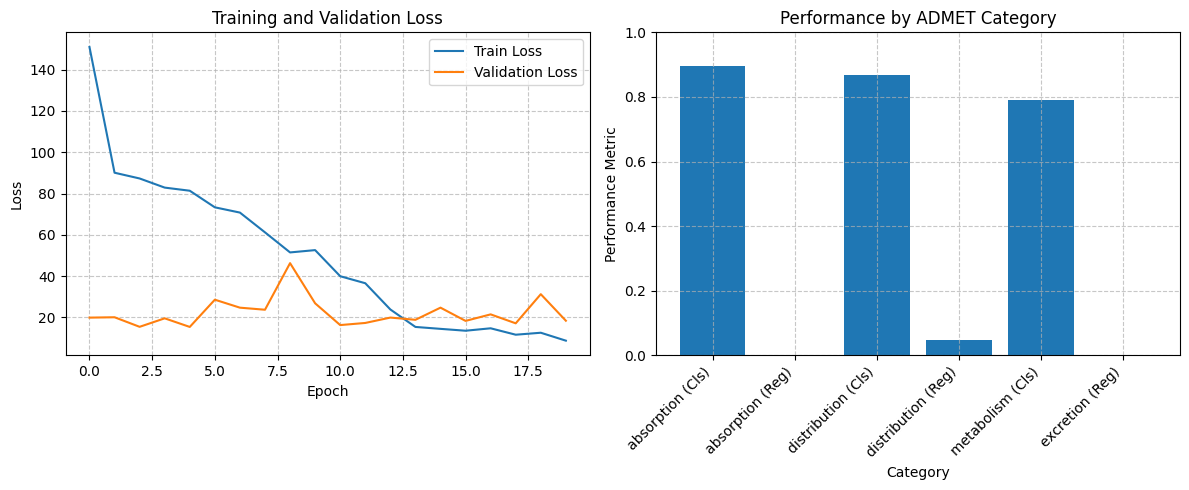

In [ ]:
# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

# 손실 곡선
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# ADMET 범주별 성능 시각화
plt.subplot(1, 2, 2)

# 범주별 성능 계산
category_metrics = {}
for epoch_metrics in history['val_metrics']:
    for dataset, metrics in epoch_metrics.items():
        category = prepared_datasets[dataset]['category']
        task_type = prepared_datasets[dataset]['task_type']

        if category not in category_metrics:
            category_metrics[category] = {'classification': [], 'regression': []}

        # 분류 작업은 AUROC, 회귀 작업은 R2 사용
        if task_type == 'classification' and 'AUROC' in metrics:
            category_metrics[category]['classification'].append(metrics['AUROC'])
        elif task_type == 'regression' and 'R2' in metrics:
            category_metrics[category]['regression'].append(metrics['R2'])

# 마지막 에폭의 범주별 성능
last_epoch_metrics = {}
for category, values in category_metrics.items():
    if values['classification']:
        last_epoch_metrics[f"{category} (Cls)"] = np.mean(values['classification'])
    if values['regression']:
        last_epoch_metrics[f"{category} (Reg)"] = np.mean(values['regression'])

categories = list(last_epoch_metrics.keys())
values = list(last_epoch_metrics.values())

plt.bar(categories, values)
plt.title('Performance by ADMET Category')
plt.xlabel('Category')
plt.ylabel('Performance Metric')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()
